In [324]:
from sage.sets.family import Family
from sage.rings.rational_field import QQ
from sage.modules.with_basis.subquotient import SubmoduleWithBasis
from sage.misc.cachefunc import cached_method
from sage.matrix.constructor import matrix
from sage.combinat.symmetric_group_algebra import e
from sage.combinat.permutation import Permutation
from sage.combinat.partition import Partition
from sage.combinat.diagram import Diagram
from sage.categories.modules_with_basis import ModulesWithBasis
from sympy.polys.matrices import DomainMatrix
from sympy.physics.quantum.matrixutils import matrix_tensor_product
from sympy.parsing.sympy_parser import parse_expr
from sympy import Matrix, SparseMatrix, eye
import matplotlib.pyplot as plt
import numpy
import os.path
import json
import itertools
import networkx as nx
Symqt = SymmetricFunctions(QQ)
s = Symqt.s()
sp = Symqt.sp()
e = Symqt.e()
p = Symqt.p()

In [325]:
from sage.categories.modules_with_basis import ModulesWithBasis
from sage.combinat.diagram import Diagram
from sage.combinat.partition import Partition
from sage.combinat.permutation import Permutation
from sage.combinat.symmetric_group_algebra import e
from sage.matrix.constructor import matrix
from sage.misc.cachefunc import cached_method
from sage.modules.with_basis.subquotient import SubmoduleWithBasis
from sage.rings.rational_field import QQ
from sage.sets.family import Family


class SpechtModuleWithBasis(SubmoduleWithBasis):
    @staticmethod
    def __classcall_private__(cls, SGA, D):
        D = _to_diagram(D)
        D = Diagram(D)
        n = len(D)
        if SGA.group().rank() != n - 1:
            rk = SGA.group().rank() + 1
            raise ValueError(
                f"the domain size (={rk}) does not match the number of boxes (={n}) of the diagram")
        return super().__classcall__(cls, SGA, D)

    def __init__(self, SGA, D):
        self._diagram = D
        Mod = ModulesWithBasis(SGA.category().base_ring())
        span_set = specht_module_spanning_set(D, SGA)
        support_order = SGA.get_order()
        basis = SGA.echelon_form(span_set, False, order=support_order)
        basis = Family(basis)
        SubmoduleWithBasis.__init__(self, basis, support_order, ambient=SGA,
                                    unitriangular=False, category=Mod.Subobjects())

    def _re_basis_representation_matrix(self, elt):
        SGA = self._ambient
        return matrix(self.base_ring(), [self.retract(SGA(elt) * b.lift()).to_vector()
                                         for b in self.basis()]).T

    def representation_matrix(self, elt):
        cob_matrix = matrix(self.base_ring(), [self.retract(permutation_for_tableau(standard_tableau)).to_vector()
                                               for standard_tableau in _to_partition(self._diagram).standard_tableaux()])

        return cob_matrix * self._re_basis_representation_matrix(elt) * cob_matrix.inverse()

    def representation_matrix_in_basis(self, basis, elt):
        cob_matrix = matrix(self.base_ring(), [self.retract(permutation_for_tableau(
            standard_tableau)).to_vector() for standard_tableau in basis])

        return cob_matrix * self._re_basis_representation_matrix(elt) * cob_matrix.inverse()

    class Element(SubmoduleWithBasis.Element):
        def _acted_upon_(self, x, self_on_left=False):
            # Check for a scalar first
            ret = super()._acted_upon_(x, self_on_left)
            if ret is not None:
                return ret
            # Check if it is in the symmetric group algebra
            P = self.parent()
            if x in P._ambient or x in P._ambient.group():
                if self_on_left:  # it is only a left module
                    return None
                else:
                    return P.retract(P._ambient(x) * self.lift())
            return None


def _to_partition(D):
    list_for_partition = []

    for box in D:
        if box[0] >= len(list_for_partition):
            list_for_partition.append(0)

        list_for_partition[box[0]] += 1

    return Partition(list_for_partition)


def _to_diagram(D):
    from sage.combinat.integer_vector import IntegerVectors
    from sage.combinat.partition import _Partitions
    from sage.combinat.skew_partition import SkewPartitions
    if isinstance(D, Diagram):
        return D
    if D in _Partitions:
        D = _Partitions(D).cells()
    elif D in SkewPartitions():
        D = SkewPartitions()(D).cells()
    elif D in IntegerVectors():
        cells = []
        for i, row in enumerate(D):
            for j in range(row):
                cells.append((i, j))
        D = cells
    else:
        D = [tuple(cell) for cell in D]
    return D


def permutation_for_tableau(tableau):
    reference_tableau = Partition(tableau.shape()).standard_tableaux()[0]
    symmetrizer = e(reference_tableau)
    return Permutation(tableau.reading_word_permutation().inverse().to_cycles()) * Permutation(reference_tableau.reading_word_permutation().to_cycles()) * symmetrizer


def specht_module_spanning_set(D, SGA=None):
    return [permutation_for_tableau(standard_tableau) for standard_tableau in _to_partition(D).standard_tableaux()]

In [326]:
def standard_basis(n):
    # Create the standard basis for an n-dimensional vector space
    basis = []

    n = Integer(n)

    for i in range(n):
        basis_element = SparseMatrix(Matrix([0] * n))
        basis_element[i] = 1
        basis.append(basis_element)

    return basis

In [327]:
def construct_tensor_algebra(max_degree):
    tensor_algebra = {1: {Partition([1]): [StandardTableau([[1]])]}}
    left_multiplication = {}

    for i in range(1, max_degree):
        degree_from = i
        degree_to = i + 1

        new_degree = {}
        new_maps = {}

        maps_to_create = set(())

        for partition in tensor_algebra[degree_from].keys():
            new_tableau_by_partition = {}

            for tableau in (tensor_algebra[degree_from])[partition]:
                for new_tableau in tableau.up():
                    new_partition = Partition(new_tableau.shape())

                    if not new_partition in new_degree:
                        new_degree[new_partition] = []

                    new_degree[new_partition].append(new_tableau)

                    maps_to_create.add((partition, new_partition))

        dimensions = {partition: [0, len(new_degree[partition])] for partition in new_degree}

        for map_to_create in maps_to_create:
            domain_dimension = len(tensor_algebra[degree_from][map_to_create[0]])
            dimensions[map_to_create[1]][1] -= domain_dimension

            new_maps[map_to_create] = SparseMatrix(dimensions[map_to_create[1]][0], domain_dimension, [0] * dimensions[map_to_create[1]][0] * domain_dimension).col_join(
                SparseMatrix(eye(domain_dimension))).col_join(SparseMatrix(dimensions[map_to_create[1]][1], domain_dimension, [0] * dimensions[map_to_create[1]][1] * domain_dimension))

            dimensions[map_to_create[1]][0] += domain_dimension

        tensor_algebra[degree_to] = new_degree
        left_multiplication[degree_from] = new_maps

    return tensor_algebra, left_multiplication

In [328]:
tensor_algebra, left_multiplication = construct_tensor_algebra(5)

In [329]:
def plot(graded_algebra_endomorphism, graded_algebra, latex, size=(10, 10)):
    def internal_label(degree, partition):
        return (f'd{degree}p' + f'{list(partition)}'[1:-1]).replace(' ', '').replace(',', 'c')

    def external_label(weight, dimension):
        return '$H^{' + f'{dimension}' + '}_{' + f'{list(partition)}'[1:-1] + '}$'

    G = nx.DiGraph()
    labels = {}

    h = len(graded_algebra[max(graded_algebra.keys())].keys()) * 1.5

    for degree_from in graded_algebra.keys():
        for i, partition in enumerate(graded_algebra[degree_from]):
            G.add_node(internal_label(degree_from, partition), pos=(
                float((i + 1 / 2.0) * h / len(graded_algebra[degree_from])), (float(degree_from) - 1) * 2))
            labels[internal_label(degree_from, partition)] = external_label(
                partition, len(graded_algebra[degree_from][partition]))

    for degree_from in graded_algebra_endomorphism.keys():
        degree_to = degree_from + 1

        for nonzero_map in graded_algebra_endomorphism[degree_from]:
            G.add_edge(internal_label(degree_from, nonzero_map[0]), internal_label(
                degree_to, nonzero_map[1]))

    plt.figure(figsize=size)
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, node_color='#fabfff')
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    if latex:
        print(nx.to_latex(G, pos, node_label=labels))

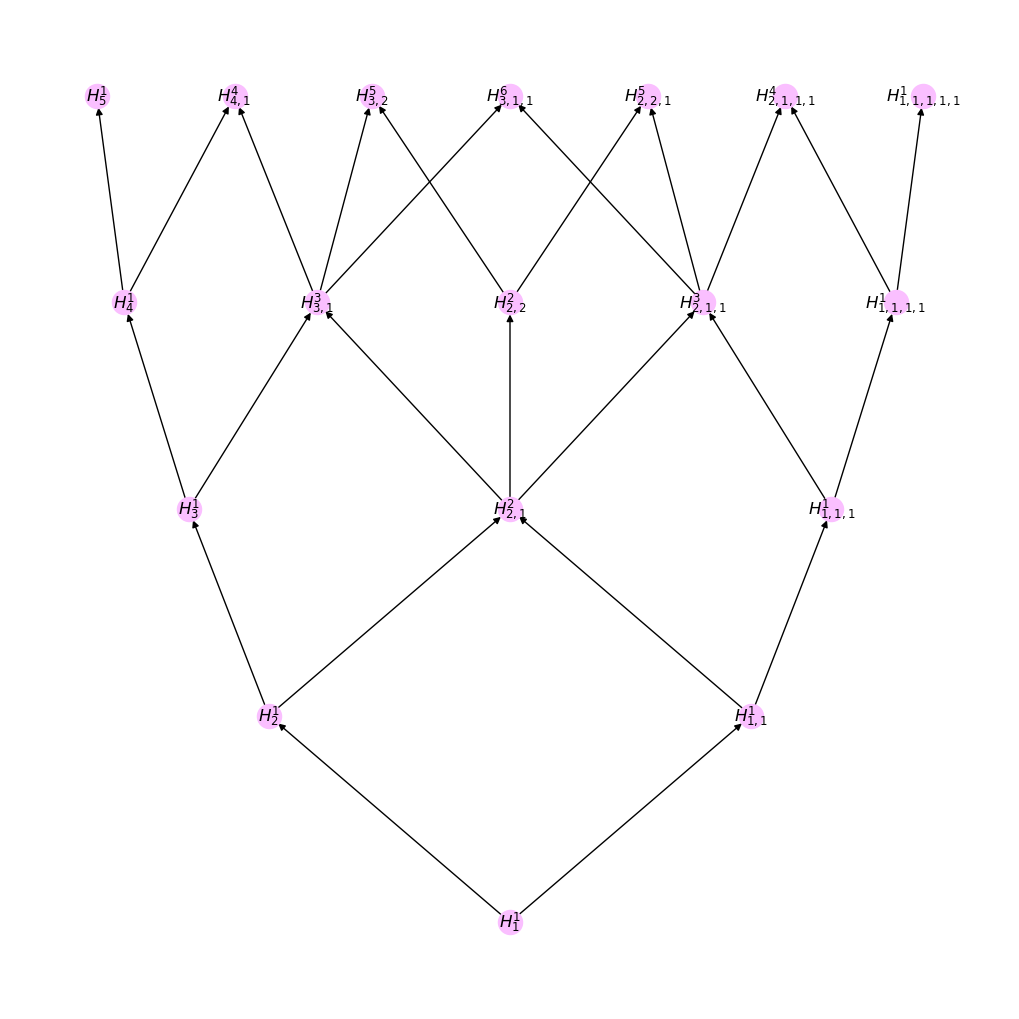

In [330]:
plot(left_multiplication, tensor_algebra, false)

In [331]:
def reverse_permutation(n):
    return Permutation(list(range(1, n + 1))[::-1])


def derive_reverse_actions(tensor_algebra):
    reverse_actions = {}

    for degree in tensor_algebra:
        for partition in tensor_algebra[degree]:
            n = sum(partition)

            specht_module = SpechtModuleWithBasis(SymmetricGroupAlgebra(QQ, n), partition)

            reverse_actions[partition] = SparseMatrix(specht_module.representation_matrix_in_basis(
                tensor_algebra[degree][partition], reverse_permutation(n)).numpy())

    return reverse_actions

In [332]:
def derive_right_multiplication(tensor_algebra, left_multiplication):
    reverse_actions = derive_reverse_actions(tensor_algebra)

    right_multiplication = {}

    for degree_from in left_multiplication:
        right_multiplication[degree_from] = {}

        for partition_from, partition_to in left_multiplication[degree_from]:
            right_multiplication[degree_from][(partition_from, partition_to)] = reverse_actions[partition_to] @ left_multiplication[degree_from][(
                partition_from, partition_to)] @ reverse_actions[partition_from]

    return right_multiplication

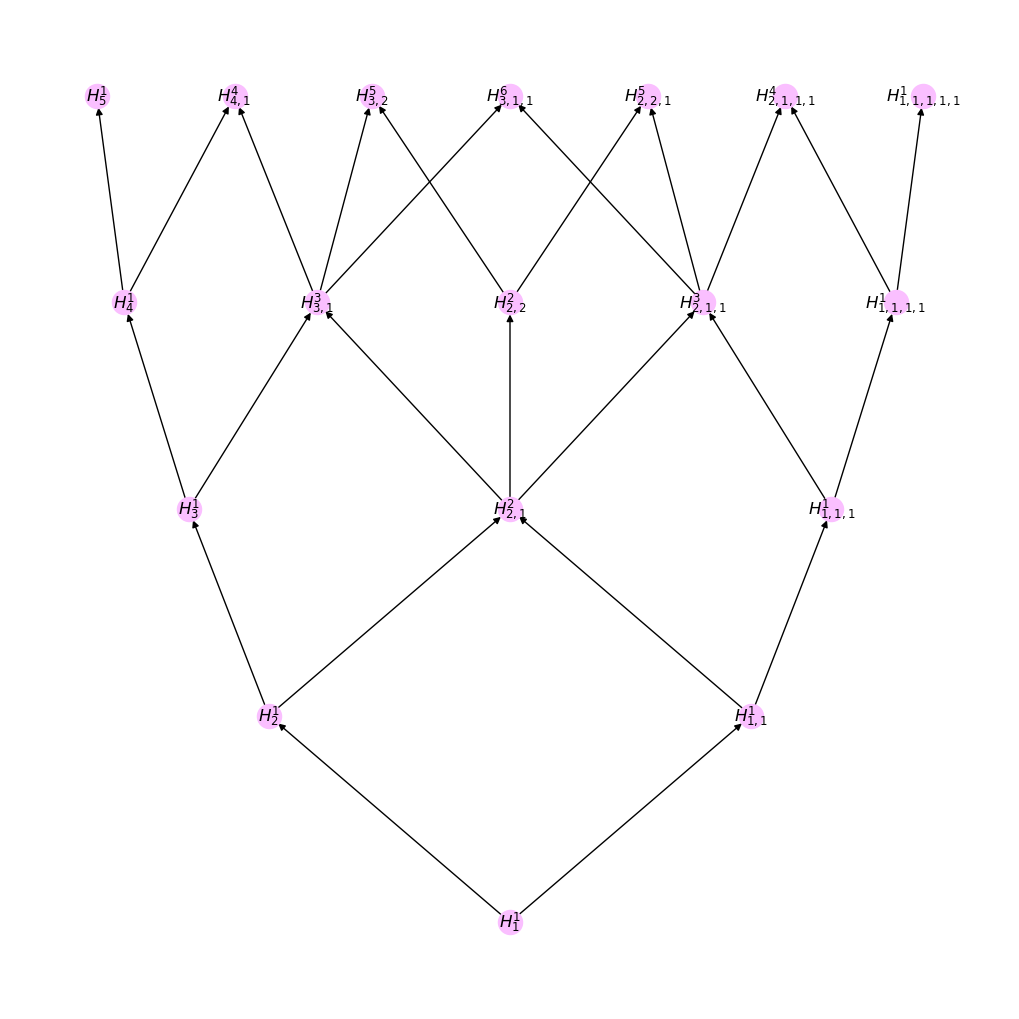

In [333]:
right_multiplication = derive_right_multiplication(tensor_algebra, left_multiplication)
plot(right_multiplication, tensor_algebra, False)

In [334]:
def construct_free_lie_algebra(n):
    tensor_algebra, left_multiplication = construct_tensor_algebra(
        n)
    right_multiplication = derive_right_multiplication(tensor_algebra, left_multiplication)

    bracket = {}

    for degree_from in left_multiplication:
        bracket[degree_from] = {}

        for non_zero_map in left_multiplication[degree_from]:
            bracket[degree_from][non_zero_map] = left_multiplication[degree_from][non_zero_map] - \
                right_multiplication[degree_from][non_zero_map]

    return bracket, tensor_algebra

In [335]:
bracket, free_lie_algebra = construct_free_lie_algebra(5)